In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.4MB/s 


In [ ]:
import tensorflow_hub as hub
import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/ISEAR.csv', header=None, names=['Emotion', 'Sentence'], index_col=0)

In [ ]:
df.head()

,Emotion,Sentence
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [ ]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Emotion'])
df.head()

,Emotion,Sentence,Label
0,joy,On days when I feel close to my partner and ot...,4
1,fear,Every time I imagine that someone I love or I ...,2
2,anger,When I had been obviously unjustly treated and...,0
3,sadness,When I think about the short time that we live...,5
4,disgust,At a gathering I found myself involuntarily si...,1


In [ ]:
df.Emotion.unique()

array(['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt'],
      dtype=object)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(7, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
max_len = 300
train_input = bert_encode(df.Sentence.values, tokenizer, max_len=max_len)
# test_input = bert_encode(test.Sentence.values, tokenizer, max_len=max_len)
# train_labels = tf.onclick="parent.postMessage({'referent':'.tensorflow.keras'}, '*')">keras.utils.to_categorical(train.label.values, num_classes=3)
train_labels = tf.keras.utils.to_categorical(df.Label.values, num_classes=7)

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2c,
    epochs=4,
    callbacks=[checkpoint, earlystopping],
    batch_size=16,
    verbose=1
)

Epoch 1/4
373/373 [==============================] - 769s 2s/step - loss: 1.8983 - accuracy: 0.2272 - val_loss: 1.0850 - val_accuracy: 0.6302

Epoch 00001: val_accuracy improved from -inf to 0.63020, saving model to model.h5
Epoch 2/4
373/373 [==============================] - 754s 2s/step - loss: 1.1503 - accuracy: 0.6104 - val_loss: 0.9714 - val_accuracy: 0.6591

Epoch 00002: val_accuracy improved from 0.63020 to 0.65906, saving model to model.h5
Epoch 3/4
373/373 [==============================] - 754s 2s/step - loss: 0.8786 - accuracy: 0.7140 - val_loss: 0.9537 - val_accuracy: 0.6745

Epoch 00003: val_accuracy improved from 0.65906 to 0.67450, saving model to model.h5
Epoch 4/4
373/373 [==============================] - 753s 2s/step - loss: 0.6914 - accuracy: 0.7647 - val_loss: 0.9771 - val_accuracy: 0.6705

Epoch 00004: val_accuracy did not improve from 0.67450


In [ ]:
history_dict = train_history.history

In [ ]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
import matplotlib.pyplot as plt

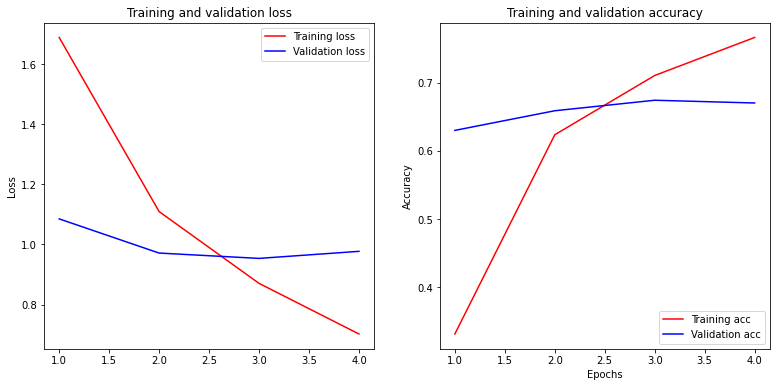

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(13, 6))
fig.tight_layout()

plt.subplot(1, 2, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'isear'
saved_model_path = '/content/gdrive/My Drive/{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/isear_bert/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/isear_bert/assets


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
mapping = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'guilt',
    4: 'joy',
    5: 'sadness',
    6: 'shame'
}

In [ ]:
train_input = bert_encode(['I am so scared to go there', 'I am feeling guilty now'], tokenizer, max_len=max_len)

pred = reloaded_model.predict(train_input)
pred

array([[9.2708174e-04, 9.3479181e-04, 9.9562138e-01, 1.1576668e-04,
        1.6631528e-04, 1.2371909e-03, 9.9755730e-04],
       [2.8543128e-04, 2.6641606e-04, 1.5728131e-04, 9.7479635e-01,
        3.9563506e-04, 3.4191622e-03, 2.0679759e-02]], dtype=float32)

In [ ]:
for value in pred:
  print(mapping[np.argmax(value)])

fear
guilt


In [ ]:
model.save("/content/gdrive/My Drive/emotion_detection_bert.h5")

In [ ]:
from tensorflow.keras.models import load_model

reloaded_model = load_model('/content/gdrive/My Drive/emotion_detection_bert.h5', custom_objects={'KerasLayer': hub.KerasLayer})

## For confusion matrix

In [ ]:
validation_data = df[-1489:]

In [ ]:
validation_encode = bert_encode(validation_data['Sentence'], tokenizer, max_len=max_len)

In [ ]:
labels = df['Label'][-1489:]

In [ ]:
predicted = np.argmax(model.predict(validation_encode), axis=-1)

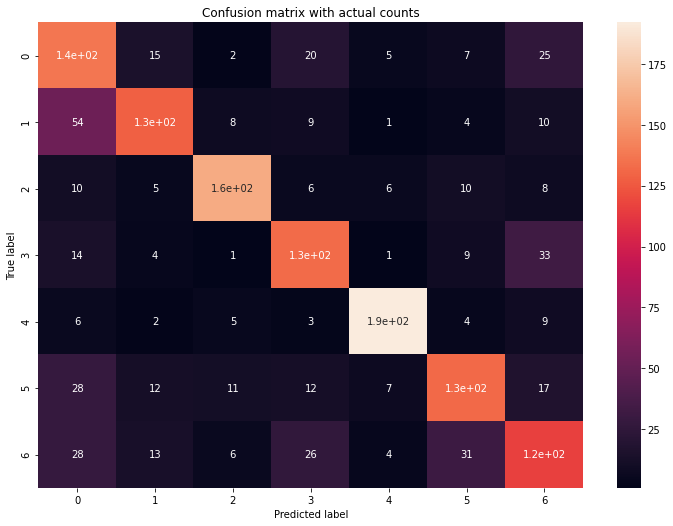

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, predicted)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,7))
#sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 10})
#plt.show()
plt.tight_layout()
plt.title('Confusion matrix with actual counts')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()